In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sqlite3

# Load the true positive predictions from the CSV file
conn = sqlite3.connect('../../../../data/nfp2/nfp2_combined.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators_combined"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)



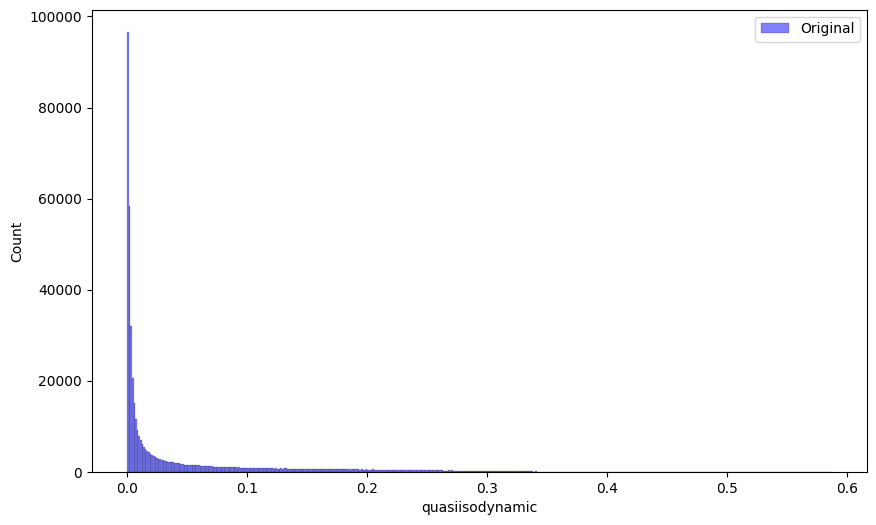

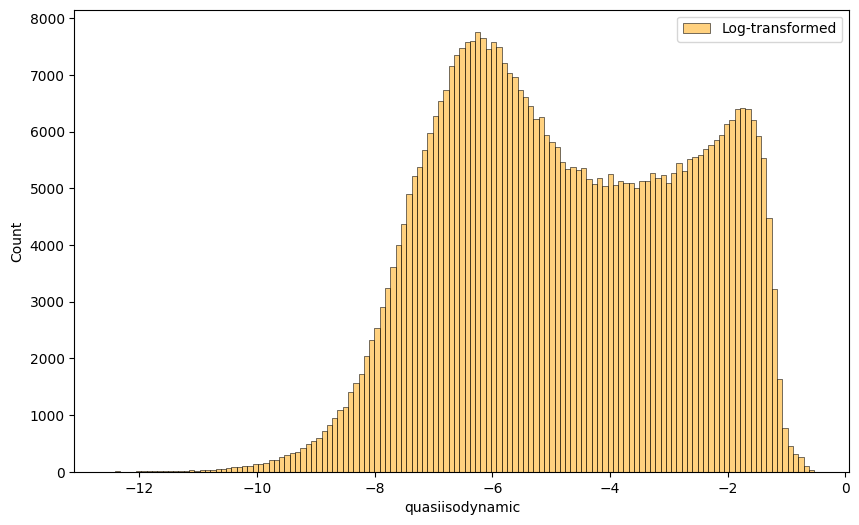

In [3]:
data_df_clean = data_df[data_df['convergence'] == 1]
data_df_clean = data_df_clean.dropna(subset=['quasiisodynamic'])


X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = np.log(data_df_clean['quasiisodynamic'])


#plot the distribution with and without log
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data_df_clean['quasiisodynamic'], color="blue", alpha=0.5, label="Original")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(Y, color="orange", alpha=0.5, label="Log-transformed") 
plt.legend()
plt.show()

# Split the data into training and testing sets
features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(X, Y, test_size=0.2, random_state=42)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
best_params_manual = {
    'boosting_type': 'dart',
    'max_depth': 139,
    'num_leaves': 1684,
    'min_data_in_leaf': 51,
    'feature_fraction': 0.9631161865696998,
    'learning_rate': 0.12654909960762645,
    'num_iterations': 2707,
    'tree_learner': 'feature'
}

# Create and train the LightGBM model with the manually defined best parameters
model = lgb.LGBMRegressor(**best_params_manual)

# Assuming features_no_outliers and target_no_outliers are your feature matrix and target vector, respectively
model.fit(features_no_outliers, target_no_outliers)

model.booster_.save_model('lightgbm_final.txt')

import matplotlib.pyplot as plt
import seaborn as sns

/home/exouser/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9631161865696998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9631161865696998
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9631161865696998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9631161865696998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 365990, number of used features: 8
[LightGBM] [Info] Start training from score -4.739438


In [ ]:
predictions = model.predict(test_features_no_outliers)

mse = mean_squared_error(test_target_no_outliers, predictions)
mae = mean_absolute_error(test_target_no_outliers, predictions)
r2 = r2_score(test_target_no_outliers, predictions)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R^2: {r2}")

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9631161865696998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9631161865696998
Test MSE: 1.2462238346273702
Test MAE: 0.8122551104999965
Test R^2: 0.7049144416490789


(91498,)
(91498,)


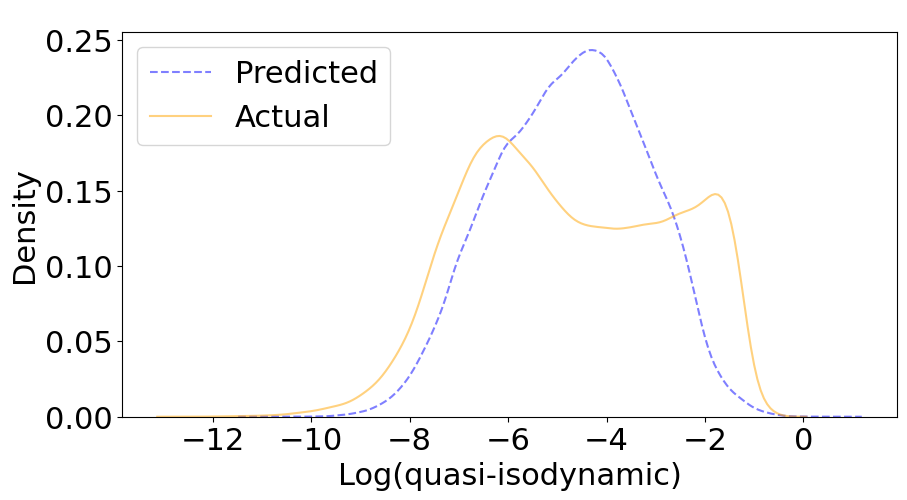

In [ ]:
# Combine and plot
#df_combined = pd.concat([df_predictions, df_actual])
print(predictions.shape)
print(test_target_no_outliers.shape)

plt.figure(figsize=(15, 5))
sns.kdeplot(predictions, fill=False, color="blue", alpha=0.5, label="Predicted", linestyle='--')
sns.kdeplot(test_target_no_outliers, fill=False, color="orange", alpha=0.5, label="Actual")
plt.title('  ')
plt.xlabel('Log(quasi-isodynamic)', fontsize = 22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Density', fontsize = 22)
plt.legend(loc='upper left', fontsize= 22)
plt.savefig('actual_vs_predictedpdf.pdf')  
plt.show()

In [4]:
import lightgbm as lgb

# Load the model
model = lgb.Booster(model_file='lightgbm_final.txt')

# Assuming 'new_data' is your new dataset
predictions = model.predict(test_features_no_outliers)

# Use the predictions as needed
print(predictions)


[-2.48309934 -3.39758893 -6.23304576 ... -5.67059408 -6.9676604
 -4.385037  ]


(91498,)
(91498,)


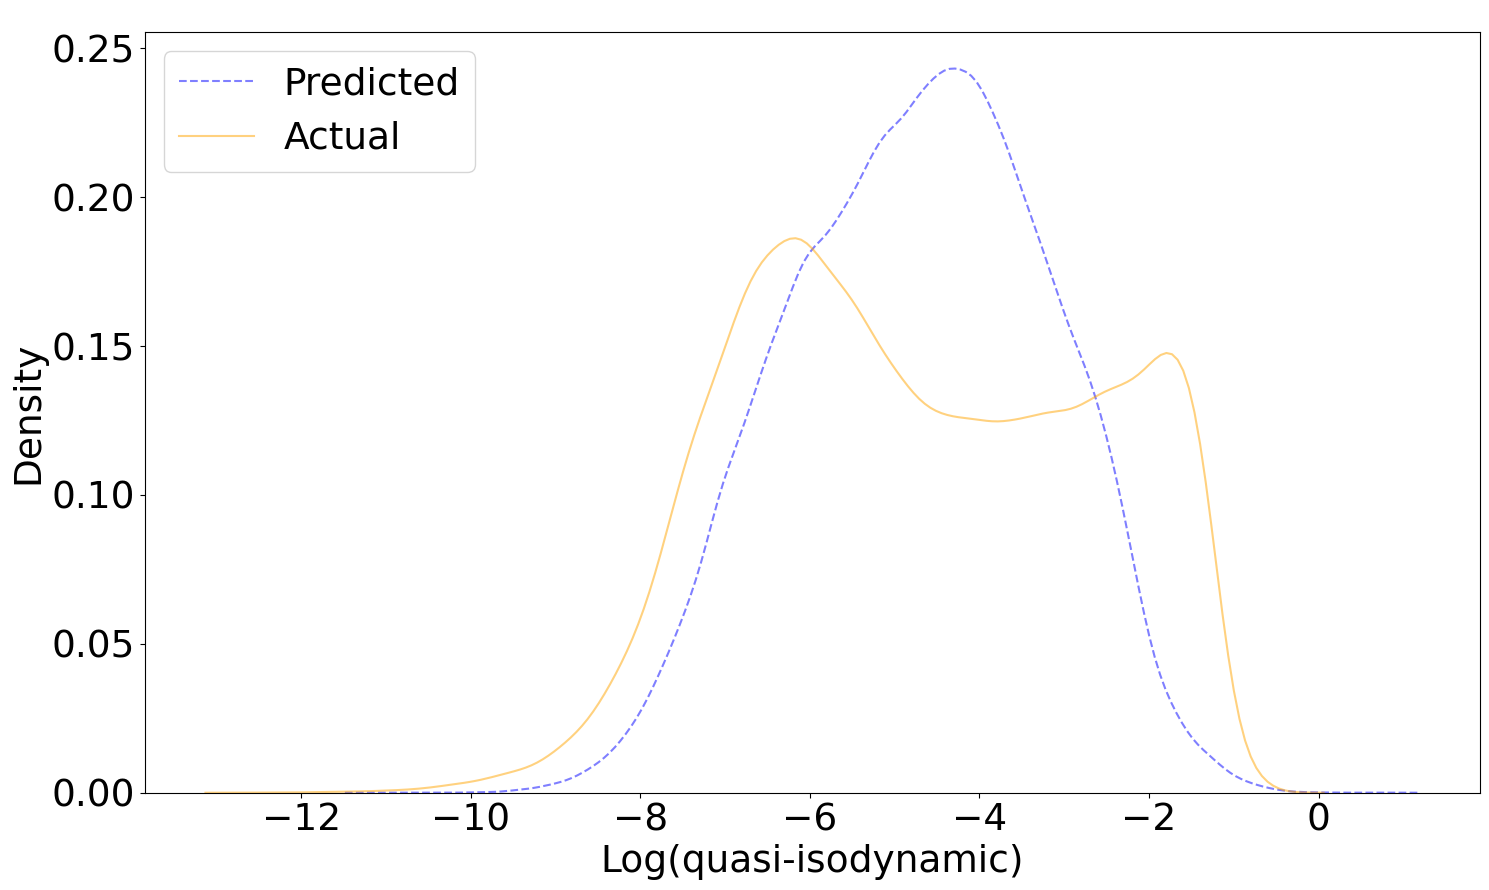

In [ ]:
# Combine and plot
#df_combined = pd.concat([df_predictions, df_actual])
print(predictions.shape)
print(test_target_no_outliers.shape)

plt.figure(figsize=(14, 10))
sns.kdeplot(predictions, fill=False, color="blue", alpha=0.5, label="Predicted", linestyle='--')
sns.kdeplot(test_target_no_outliers, fill=False, color="orange", alpha=0.5, label="Actual")
plt.title('  ')
plt.xlabel('Log(quasi-isodynamic)', fontsize = 27)
plt.ylabel('Density', fontsize = 27)
plt.legend(loc='upper left', fontsize= 27)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)

plt.tight_layout()

plt.savefig('actual_vs_predictedpdf.pdf', bbox_inches='tight')  
plt.show()

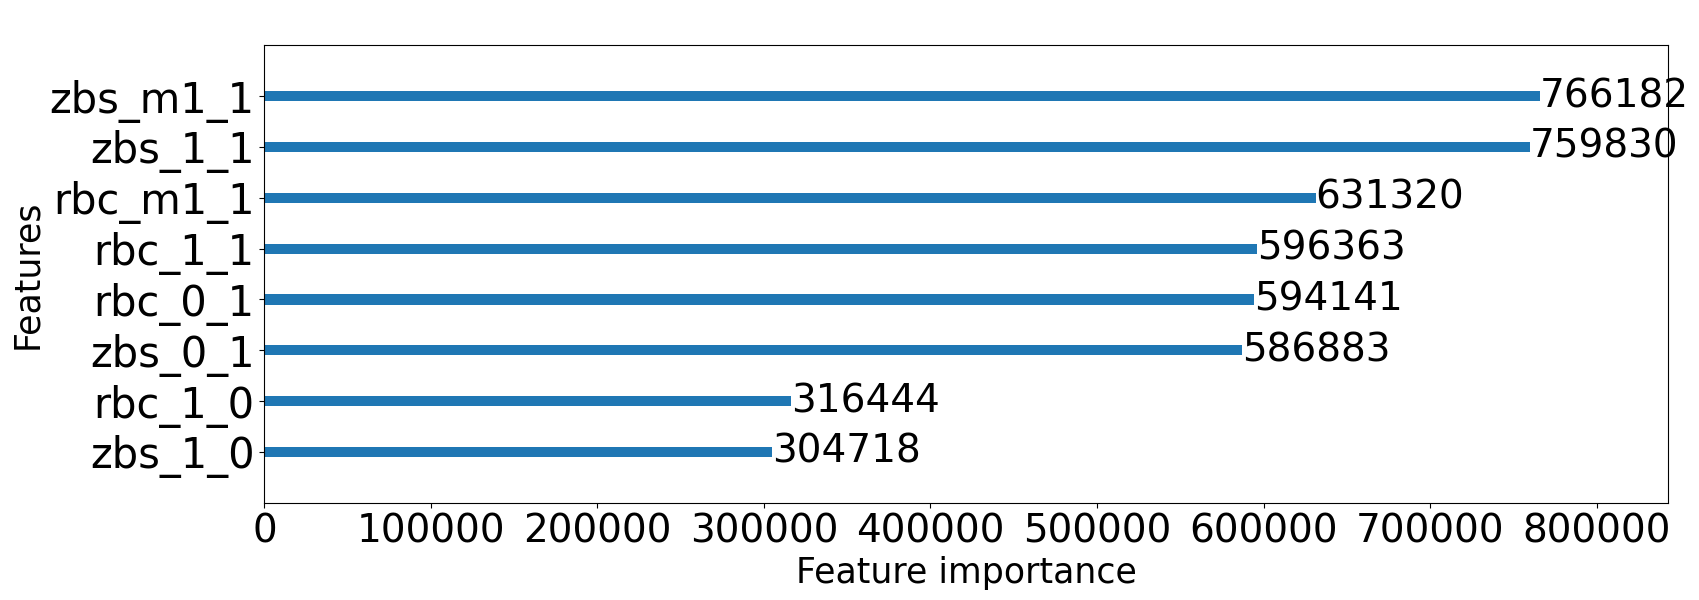

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Update general font sizes for the plot
plt.rcParams.update({
    'font.size': 40,          # General font size
    'axes.titlesize': 28,     # Title font size
    'axes.labelsize': 28,     # Label font size
    'xtick.labelsize': 28,    # X-axis tick label size
    'ytick.labelsize': 30     # Y-axis tick label size
})

# Generate the plot with LightGBM
ax = lgb.plot_importance(model, max_num_features=10, grid=False, importance_type='split')

# Set title, x-label, and y-label font sizes explicitly
ax.set_title(' ', fontsize=25)
ax.set_xlabel('Feature importance', fontsize=25)
ax.set_ylabel('Features', fontsize=25)

# Increase font size of the numbers (text annotations) next to the bars
for text in ax.texts:
    text.set_fontsize(28)  # Adjust the font size for text annotations

# Adjust the figure size and ensure numbers fit inside the plot box
fig = ax.figure  # Get the figure associated with the axes
fig.set_size_inches(18, 7)  # Adjust the figure size
fig.tight_layout()  # Ensure layout fits well

## Save and display the plot
plt.savefig('feature_importance_lightgbm.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [9]:
mse = mean_squared_error(test_target_no_outliers, predictions)
print(mse)

1.2462238346273702
